In [1]:
"""
Created on Sun Mar 29 15:40:11 2020 @author: Talha
Most of this code comes from "walkthrough" tutorial on Tracky website: http://soft-matter.github.io/trackpy/v0.4.2/tutorial/walkthrough.html
and ideas on stepsize implementation from Han Yang's code
"""
#Use Jupyter notebooks to make use of your multi-core processors; before importing trackpy to allow multi-core processing use the magic command: %%px
#Don't forget to turn on the "IPython Clusters" in Jupyter to enjoy better speeds using parallel computing

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
#%env PYTHONHASHSEED=0#important command to get reproducible results of D from cut traj using trackpy 5.0, but slows down code

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import csv
import os
import scipy as sp
from scipy import signal
from itertools import chain

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='red')

from ipyparallel import Client
client = Client()
view = client.load_balanced_view()
import trackpy as tp
tp.quiet()

In [2]:
%%px
import trackpy as tp

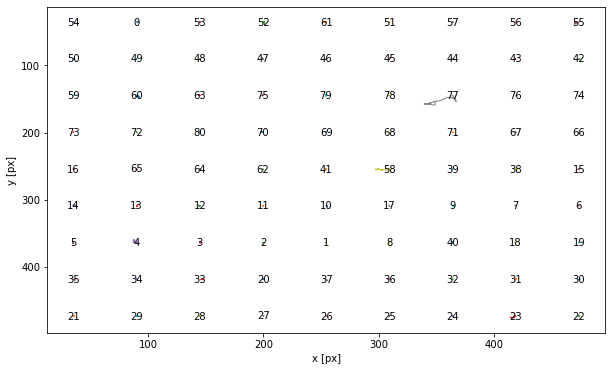

Before: 81 After: 81
The median stepsize is 28.662 nm
The median diffusion coefficient is 1.678 nm²/s


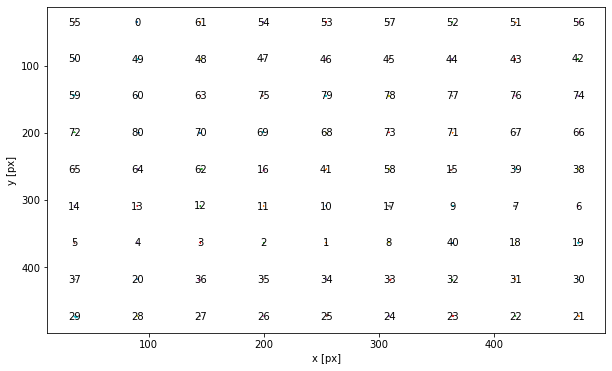

Before: 81 After: 81
The median stepsize is 26.726 nm
The median diffusion coefficient is 0.904 nm²/s


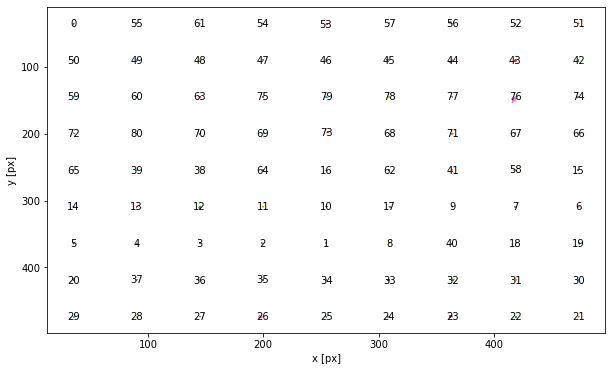

Before: 81 After: 81
The median stepsize is 27.461 nm
The median diffusion coefficient is 0.849 nm²/s


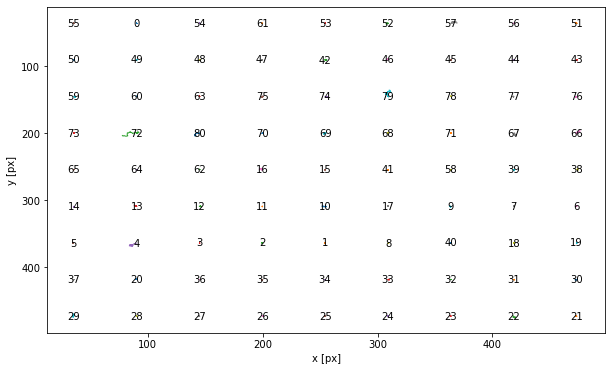

Before: 81 After: 81
The median stepsize is 28.739 nm
The median diffusion coefficient is 0.935 nm²/s


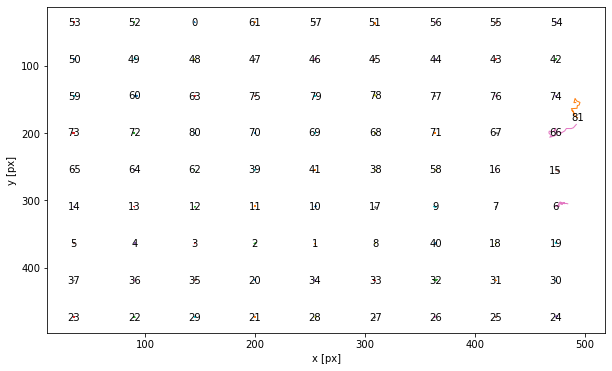

Before: 82 After: 80
The median stepsize is 27.667 nm
The median diffusion coefficient is 0.689 nm²/s


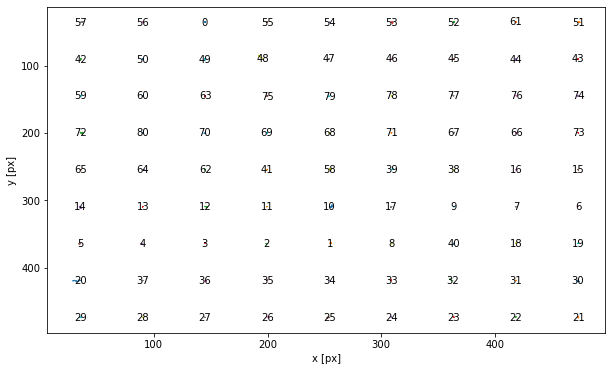

Before: 81 After: 81
The median stepsize is 27.516 nm
The median diffusion coefficient is 0.873 nm²/s


In [7]:
FRAMETIME_LIST = [4,10,20,40]#I had named the directories as my tbf values
for i in FRAMETIME_LIST:
    directory = "F:/highNoise_ergodicity/1D/12x/"+str(i)
    #fps= 1/tbf
    fps = 1/i 
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            #save your movie as tiff using Imagej before opening it here!
            frames = pims.TiffStack((directory+ '/' + filename), as_grey=True)#opens the tiffstack of movie frames
            frames_preload = list(frames[:])#load all frames

            # tp.batch, which calls tp.locate on each frame and collects the results
            #f = tp.batch(frames_preload[:1998], 7, minmass=29000, max_iterations=1, characterize=False, processes="auto");
            ###36 in the line below refers to the 36 frames simulation
            f = tp.batch(frames_preload[:36], 7, minmass=170, characterize=False, processes="auto");#radius is always an odd number

            #implementats Crocker-Grier linking algorithmto link trajectories, needs to specify a maximum displacement between adjacent frames
            #Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance
            t = tp.link_df(f, 10, memory=15)
            plt.figure()
            tp.plot_traj(t, label=True, superimpose=None);

            # Compare the number of particles in the unfiltered and filtered data 
            # that last for a given number of frames.
            t1 = tp.filter_stubs(t, 30)
            print('Before:', t['particle'].nunique(),'After:', t1['particle'].nunique())

            #Stepsize Calculation by frame:
            i=0
            j=1
            stepsize_list = []
            for i in range(len(frames_preload)-1):
                mtn = tp.motion.relate_frames(t1, i, j)#Find the displacement vector of all particles between two frames
                #remember to change the multiples for 169 pixel and 254 pixels microscopes to calculate stepsizes accurately
                step = np.sqrt((mtn.dx**2) + (mtn.dy**2))*169
                #print(mtn)
                #print(step)
                i = i+1
                j = j+1
                stepsize_list.append(step[:].tolist())
            steps = list(chain.from_iterable(stepsize_list))#make the combined list of stepsizes from all the frames
            med_step = np.nanmedian(steps)##calculates the median step size
            print(r'The median stepsize is {0:.3f} nm'.format(med_step))

            #saves step sizes in a text file
            name = filename.replace(".","_")
            completeName = os.path.join(directory, name+"_step.txt")
            with open(completeName, 'w') as f:
                for s in steps:
                    f.write("%s\n" % s)

            #Compute the mean squared displacement for every molecule
            im = tp.imsd(t1, 0.169, fps, max_lagtime=6)# microns per pixel = 0.254 or 0.169 respectively, frames per second = 1/tbf, D calculated from first 6 pts
            m, b = np.polyfit(im.index, im, 1)
            #calculates D for every molecule
            D = (m/4)*(10**6)
            #print(D)
            med = np.median(D)#calculates the median D
            print(r'The median diffusion coefficient is {0:.3f} nm²/s'.format(med))

            #saves Diffusion coefficients in a csv file
            np.savetxt((directory + '/' + name) +'_D.csv', D, delimiter=',', comments="")